## Double Q-Learning

In this assignment, I will explore the Double Q-Learning algorithm as proposed in [Hasselt, 2010](https://papers.nips.cc/paper/3964-double-q-learning).

Some theoretical aspect of the algorithm will be explored and using a small stochastic environment we will look at performance in comparison to regular Q-Learning.

### Background

As a reminder, the regular Q-Learning update rule is as follows:

$Q_{t+1}(s_t, a_t) = Q_{t}(s_t, a_t) + \alpha_t(s_t, a_t) \big(r_t + \gamma \max_a Q_{t}(s_{t+1}, a_t) - Q_{t}(s_t, a_t) \big)$

One of the major advantage of Q-Learning is its use of the value of the maximally valued action at the upcoming state to update the value of the current state-action pair. In general, this is highly desired as it gives conceptually a great estimate of the current state.

However, the article mentions that this advantage can be costly as it overestimates the value of a state-action pair based on the observed rewards. Under a deterministic environment, it can be understood that this does not apply, but under a stochastic environment it should be considered as maybe the value obtained shouldn't be so much trusted.

The authors then expand by mentionning a double estimator that will provide an estimate of the maximum value of the new state that allows to reduce that overestimation, which is the Double Q-Learning algorithm.

### Theoretical aspect of Double Q-Learning

The goal of this method is to reduce the risk of estimation of the state-action pair by using a second estimator. The authors argue using the following lemma that Double Q-Learning indeed reduces the the overestimation.

##### Lemma
> Let $X=\{X_1, \dots, X_M\}$ be a set of random variables and let $\mu^A=\{\mu_1^A, \dots, \mu_M^A\}$ and $\mu^B=\{\mu_1^B, \dots, \mu_M^B\}$ be two sets of unbiased estimators such that $E\{\mu_i^A \} = E\{\mu_i^B \} = E\{X_i \}$, for all $i$. Let $\mathcal{M} \doteq \big \{ j  \vert E\{ X_j \} = \max_i E\{ X_i \} \big \}$ be the set of elements that maximize the expected values. Let $a^*$ be an element that maximizes $\mu^A:\mu^A_{a^*} = \max_i \mu^A_i$.
>
> Then $E\{\mu_{a^*}^B \} = E\{X_{a^*} \} \le \max_i E\{X_i \}$.
>
> Furthermore, the inequality is stict if and only if $P(a^* \notin \mathcal{M}) \gt 0$.

#### What does this mean?

The above mentioned lemma proposed by the authors means that the expected value obtained by the second estimator which is based on the maximal value of the first estimator must be lower or equal to the expected value of the maximally value sampled variable.

Here the last term $\max_i E\{X_i \}$ represents the Q-Learning algorithm with $\max_a E\{Q_t(s_{t+1}, a_t) \}$, where according to that algorithm, we evaluate a state-action as its highest sampled reward.

The authors argued that the Q-Learning algorithms overestimates the values. Their point is that using a double estimator as just described above ($E\{\mu_{a^*}^B \}$) is guaranteed to be lower than or equal to the Q-Learning value, therefore reducing the risk of overestimation.

#### Proof of lemma

Here is a quick rundown of the proof provided in the article with regards to this lemma.

> Assume $a^* \in \mathcal{M}$, then $E\{\mu_{a^*}^B \} = E\{X_{a^*} \} = E\{X_{j} \} \doteq \max_i E\{X_i \}$

This is true as per the definition of $\mathcal{M}$ being a set of possibilities that maximize $E\{X_{i} \}$.

> Now assume that $a^* \notin \mathcal{M}$, then $E\{\mu_{a^*}^B \} = E\{X_{a^*} \} \lt E\{X_{j} \} \doteq \max_i E\{X_i \}$

This is also true because by definition, if it's not part of $\mathcal{M}$, it doesn't maximize $E\{X_{i} \}$ and therefore needs to be less.

The authors then shows that since these two possibilities are mutually exclusive (either being or not in $\mathcal{M}$), the expectation can be rewritten as the following.

> $\begin{align}
E\{\mu_{a^*}^B \} &= E\{\mu_{a^*}^B \vert a^* \in \mathcal{M} \} P(a^* \in \mathcal{M}) + E\{\mu_{a^*}^B \vert a^* \notin \mathcal{M} \} P(a^* \notin \mathcal{M}) & \\
&= \max_i E\{X_i \} P(a^* \in \mathcal{M}) + E\{\mu_{a^*}^B \vert a^* \notin \mathcal{M} \} P(a^* \notin \mathcal{M}) 
\end{align}$

This is true as per just above mentioned elements, we can also provide an upper bound for $E\{\mu_{a^*}^B \vert a^* \notin \mathcal{M} \}$, furthermore due to the possibilities being mutually exclusive we can simplify,

> $\begin{align}
E\{\mu_{a^*}^B \} &= \max_i E\{X_i \} P(a^* \in \mathcal{M}) + E\{\mu_{a^*}^B \vert a^* \notin \mathcal{M} \} P(a^* \notin \mathcal{M}) \\
&\le \max_i E\{X_i \} P(a^* \in \mathcal{M}) + \max_i E\{X_i \} P(a^* \notin \mathcal{M}) \\
&\le \max_i E\{X_i \}
\end{align}$

### The algorithm

The goal of the algorithm is to have two Q-value functions (tables) that are used as target for the other one's update. Before updating, we select at random a Q-value table that will be updated and use the other one not being updated to get the value of the new maximum value for the new state.

When choosing an action, the authors recommend averaging the Q-value form both tables to get which one is the best.

Here is the algorithm in detail as per their article:
<img src="double-Q-learning-algo.png">

### Testing the algorithm

To compare performance, we will be using the Open Ai gym, more specifically the FrozenLake environment, with modified rewards to insert additional stochasticity in the reward. In addition to basic reward system, at each non-terminal a random reward uniformly distributed between (-1.5, 0.5) is provided.

This environment is basically a windy gridworld problem, where the agent can fall in the hole in the grid and the episode ends without a reward, otherwise a reward of 1 is provided when the goal is reached. Not all moves executed by the agent end up happening as planned due to wind.

For more information on the environment, refer to [this page](https://gym.openai.com/envs/FrozenLake-v0).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
import pandas
import pickle as pkl

In [2]:
env = []
env.append(gym.make('FrozenLake-v0')) # Used for Regular Q-Learning
env.append(gym.make('FrozenLake-v0')) # Used for Double Q-Learning
print 'Regular Q-Learning'
env[0].render()
print 'Double Q-Learning'
env[1].render()

[2017-03-15 01:23:28,481] Making new env: FrozenLake-v0
[2017-03-15 01:23:28,519] Making new env: FrozenLake-v0


Regular Q-Learning
SFFF
FHFH
FFFH
HFFG

Double Q-Learning
SFFF
FHFH
FFFH
HFFG



In [3]:
nb_states = env[0].observation_space.n
nb_actions = env[0].action_space.n

# Settings for learning
nb_episodes = 10000
eps_init = 1.0
lr_init = 0.2
eps_decay = 0.999
lr_decay = 0.999
gamma = 0.9

#### Regular Q-Learning

In [4]:
eps = eps_init
lr = lr_init
Q = np.zeros((nb_states, nb_actions)) # Used for regular Q-Learning
ep_rwrds_q = np.zeros(nb_episodes)
for n in xrange(nb_episodes):

    # reset the environment
    curr_state = env[0].reset()

    # reset params for the episode
    steps = 1
    tot_rwrd = 0
    done = False

    # loop until end of episode
    while not done:

        if np.random.random_sample() <= eps:
            # choose action at random
            action = env[0].action_space.sample()
        else:
            # choose greedy action
            action = np.argmax(Q[curr_state, :])

        # get new_state, reward for action and if reached the goal
        new_state, rwrd, done, _ = env[0].step(action)

        if not done:
            rwrd = 2 * np.random.random_sample() - 1.5

        # Apply regular Q-learning
        max_action = np.argmax(Q[new_state, :]) # get max action at new state
        error = rwrd + gamma * Q[new_state, max_action] - Q[curr_state, action]
        Q[curr_state, action] += lr * error

        curr_state = new_state
        tot_rwrd += rwrd
        steps += 1

    # Store results
    ep_rwrds_q[n] += tot_rwrd

    if n % (nb_episodes / 10) == 0:
        print '- Regular Q ep %s -- (lr, eps) (%s, %s)' %(n, np.round(lr, 5), np.round(eps, 5))

    # Decay for next episode
    eps *= eps_decay
    lr *= lr_decay

- Regular Q ep 0 -- (lr, eps) (0.2, 1.0)
- Regular Q ep 1000 -- (lr, eps) (0.07354, 0.3677)
- Regular Q ep 2000 -- (lr, eps) (0.02704, 0.1352)
- Regular Q ep 3000 -- (lr, eps) (0.00994, 0.04971)
- Regular Q ep 4000 -- (lr, eps) (0.00366, 0.01828)
- Regular Q ep 5000 -- (lr, eps) (0.00134, 0.00672)
- Regular Q ep 6000 -- (lr, eps) (0.00049, 0.00247)
- Regular Q ep 7000 -- (lr, eps) (0.00018, 0.00091)
- Regular Q ep 8000 -- (lr, eps) (7e-05, 0.00033)
- Regular Q ep 9000 -- (lr, eps) (2e-05, 0.00012)


#### Double Q-Learning

In [5]:
eps = eps_init
lr = lr_init
DQ = np.zeros((2, nb_states, nb_actions)) # Used for Double Q-Learning
ep_rwrds_dq = np.zeros(nb_episodes)
for n in xrange(nb_episodes):

    # reset the environment
    curr_state = env[1].reset()

    # reset params for the episode
    steps = 1
    tot_rwrd = 0
    done = False

    # loop until end of episode
    while not done:

        if np.random.random_sample() <= eps:
            # choose action at random
            action = env[1].action_space.sample()
        else:
            # choose greedy action based on avg of Q-value functions
            action = np.argmax(np.average(DQ, axis=0)[curr_state, :])

        # get new_state, reward for action and if reached the goal
        new_state, rwrd, done, _ = env[1].step(action)

        if not done:
            rwrd = 2 * np.random.random_sample() - 1.5

        # Apply Double Q-learning
        rdm_Q = np.random.randint(2) # choose Q-value that will be updated
        max_action = np.argmax(DQ[rdm_Q, new_state, :]) # get max action at new state

        # The error is calculated using the other Q-value function
        error = rwrd + gamma * DQ[1 - rdm_Q, new_state, max_action] - DQ[rdm_Q, curr_state, action]

        # Update is performed on selected Q-value function
        DQ[rdm_Q, curr_state, action] += lr * error

        curr_state = new_state
        tot_rwrd += rwrd
        steps += 1

    # Store results
    ep_rwrds_dq[n] += tot_rwrd

    if n % (nb_episodes / 10) == 0:
        print '- Double Q ep %s -- (lr, eps) (%s, %s)' %(n, np.round(lr, 5), np.round(eps, 5))

    # Decay for next episode
    eps *= eps_decay
    lr *= lr_decay

- Double Q ep 0 -- (lr, eps) (0.2, 1.0)
- Double Q ep 1000 -- (lr, eps) (0.07354, 0.3677)
- Double Q ep 2000 -- (lr, eps) (0.02704, 0.1352)
- Double Q ep 3000 -- (lr, eps) (0.00994, 0.04971)
- Double Q ep 4000 -- (lr, eps) (0.00366, 0.01828)
- Double Q ep 5000 -- (lr, eps) (0.00134, 0.00672)
- Double Q ep 6000 -- (lr, eps) (0.00049, 0.00247)
- Double Q ep 7000 -- (lr, eps) (0.00018, 0.00091)
- Double Q ep 8000 -- (lr, eps) (7e-05, 0.00033)
- Double Q ep 9000 -- (lr, eps) (2e-05, 0.00012)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


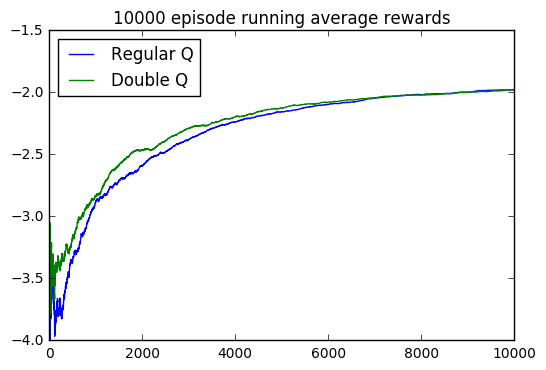

In [50]:
x = xrange(nb_episodes)
avg_size = nb_episodes

print_q = ep_rwrds_q
print_dq = ep_rwrds_dq

y_q = pandas.rolling_mean(print_q, avg_size, min_periods=1)
y_dq = pandas.rolling_mean(print_dq, avg_size, min_periods=1)

plt.plot(x, y_q, label='Regular Q')
plt.plot(x, y_dq, label='Double Q')
plt.title('%s episode running average rewards' %avg_size)
ymin, ymax = plt.ylim()
plt.ylim((-4, -1.5))
plt.legend(loc=2)
plt.show()

#### Experimental results

We immediately notice the slight superior performance during the first 4,000 steps of Double Q-Learning in this small experiment under a stochastic environment. It is however important to point out that after 4,000 steps, Regular Q-Learning does catch up, and ultimately both converge to the same policy and average reward, which is to be anticipated.


#### Discussion
In order to reduce even more the chance of overestimation increase stability in Q-Learning, one could construct a wide array of Q-values and apply the same logic. One alternative is known as Multi Q-Learning as introduced in [Duryea *et al.*, 2016](http://dx.doi.org/10.4236/ica.2016.74012). The authors argue that implementing this new algorithm allows to increase stability, in particular for situations like non-linear function approximation such as by using deep neural nets.